In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trading/example-game.json


# Loading data

In [3]:
import json
from pprint import pprint

# Specify the file path
file_path = '/kaggle/input/trading/example-game.json'  # Replace with your actual file path

# Read and parse the JSON file
with open(file_path, 'r') as f:
    data = json.load(f)

if isinstance(data, list):
    pprint(data[2], indent=2)  # Pretty print first 5 items if data is a list

{ 'assist_player': None,
  'away_score': 0,
  'coordinate_x': None,
  'coordinate_y': None,
  'event_type': 'NOTHING',
  'home_away': 'unknown',
  'home_score': 0,
  'player_name': None,
  'rebound_type': None,
  'shot_type': None,
  'substituted_player_name': None,
  'time_seconds': 2879.0}


# Score Exploration

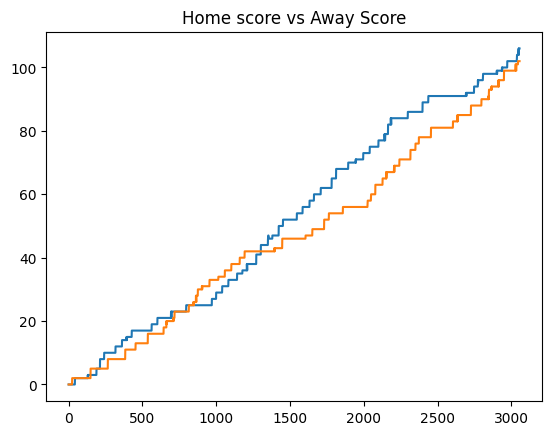

In [18]:
import matplotlib.pyplot as plt

num_events = len(data)

home_score = []
away_score = []
time = []

for i in range(num_events):
    home_score.append(data[i]["home_score"])
    away_score.append(data[i]["away_score"])
    time.append(i)

plt.plot(time, home_score)
plt.plot(time, away_score)
plt.title("Home score vs Away Score")
plt.show()

# Trading Strategy

In [5]:
from enum import Enum
from typing import Optional
from typing import Dict, Tuple
import math
from collections import deque  # Added for sliding window of recent events

# Enums for defining trade sides and tickers
class Side(Enum):
    BUY = 0  # Represents a buy order
    SELL = 1  # Represents a sell order

class Ticker(Enum):
    TEAM_A = 0  # Represents the asset being traded (TEAM_A)

# Function to place a market order
def place_market_order(side: Side, ticker: Ticker, quantity: float) -> None:
    """Places a market order to buy or sell a specified quantity of shares."""
    print(f"Market order: {side} {quantity} shares of {ticker}")

# Function to place a limit order
def place_limit_order(side: Side, ticker: Ticker, quantity: float, price: float, ioc: bool = False) -> int:
    """Places a limit order at a specified price, returns a mock order ID."""
    print(f"Limit order: {side} {quantity} shares of {ticker} @ ${price:.2f}")
    return hash((side, ticker, quantity, price))  # Generates a unique order ID

# Function to cancel an existing order
def cancel_order(ticker: Ticker, order_id: int) -> bool:
    """Cancels an order by ticker and order ID, returns True if successful."""
    print(f"Cancel order: {ticker} order_id={order_id}")
    return True  # Always returns True for mock cancellation

# Main trading strategy class
class Strategy:
    def __init__(self) -> None:
        """Initializes the strategy by resetting state variables."""
        self.reset_state()

    def reset_state(self) -> None:
        """Resets all state variables to initial values, used at game start/end."""
        self.current_price = None  # Current market price of TEAM_A
        self.position = 0  # Current number of shares held
        self.capital = 100000.0  # Starting capital for trading
        self.open_orders = {}  # Dictionary of open orders {order_id: (side, price)}
        self.score_diff = 0  # Difference between home and away scores
        self.last_time = 2880  # Total game duration in seconds (48 minutes)
        self.orderbook_buy_volume = 0  # Total volume of buy orders in order book
        self.orderbook_sell_volume = 0  # Total volume of sell orders in order book
        self.orderbook_best_bid = None  # Highest bid price in order book
        self.orderbook_best_ask = None  # Lowest ask price in order book
        self.max_position = 50  # Maximum shares allowed to hold
        self.prior_prob = 0.5  # Initial Bayesian prior probability of winning
        self.bids = {}  # Dictionary of bid prices and quantities
        self.asks = {}  # Dictionary of ask prices and quantities
        self.home_momentum = 0  # Momentum score for home team
        self.away_momentum = 0  # Momentum score for away team
        self.decay_lambda = 0.01  # Decay factor for momentum weighting
        self.recent_events = deque()  # Sliding window of recent game events
        self.window_seconds = 120  # Time window for momentum (2 minutes)
        self.peak_capital = self.capital  # Initial peak is starting capital
        self.drawdown_limit = 0.05  # 5% drawdown threshold
        self.paused = False  # Pause trading on drawdown breach
        self.highest_price = None  # Track highest price for trailing stop
        self.trailing_stop_pct = 0.05  # 5% trailing stop percentage

    def on_trade_update(self, ticker: Ticker, side: Side, quantity: float, price: float) -> None:
        """Handles trade updates, updating market price and checking stop-loss."""
        self.current_price = price  # Update current market price
        self.check_stop_loss()  # Check if stop-loss should be triggered
        print(f"Python Trade update: {ticker} {side} {quantity} shares @ ${price:.2f}")

    def on_account_update(self, ticker: Ticker, side: Side, price: float, quantity: float, capital_remaining: float) -> None:
        """Updates account state (capital, position) after a trade."""
        self.capital = capital_remaining  # Update remaining capital
        if side == Side.BUY:
            self.position += quantity  # Increase position for buys
        elif side == Side.SELL:
            self.position -= quantity  # Decrease position for sells
        print(f"Account update: {ticker} {side} {quantity} @ ${price:.2f}, Capital: ${self.capital:.2f}, Position: {self.position}")

        if self.capital > self.peak_capital:
            self.peak_capital = self.capital

        # Calculate drawdown and check limit
        drawdown_pct = (self.peak_capital - self.capital) / self.peak_capital if self.peak_capital > 0 else 0
        
        if drawdown_pct > self.drawdown_limit:
            print(f"Drawdown limit exceeded ({drawdown_pct:.2%} > {self.drawdown_limit:.2%}): Pausing trading and liquidating.")
            self.paused = True
            if self.position > 0:
                place_market_order(Side.SELL, Ticker.TEAM_A, self.position)
                print(f"Emergency liquidation: Sold {self.position} shares due to drawdown.")

    def on_orderbook_update(self, ticker: Ticker, side: Side, quantity: float, price: float) -> None:
        """Updates order book state (bids/asks) to track market sentiment."""
        if side == Side.BUY:
            # Update bid dictionary
            if price not in self.bids:
                self.bids[price] = 0  # Initialize bid price if not present
            old_bid_volume = self.bids[price]
            self.bids[price] += quantity  # Update bid quantity
            if self.bids[price] <= 0:
                self.orderbook_buy_volume -= old_bid_volume  # Remove volume if zero
                del self.bids[price]
            else:
                self.orderbook_buy_volume += quantity  # Incremental volume update
            # Update best bid price
            if self.bids:
                self.orderbook_best_bid = max(self.bids.keys())
            else:
                self.orderbook_best_bid = None
        elif side == Side.SELL:
            # Update ask dictionary
            if price not in self.asks:
                self.asks[price] = 0  # Initialize ask price if not present
            old_ask_volume = self.asks[price]
            self.asks[price] += quantity  # Update ask quantity
            if self.asks[price] <= 0:
                self.orderbook_sell_volume -= old_ask_volume  # Remove volume if zero
                del self.asks[price]
            else:
                self.orderbook_sell_volume += quantity  # Incremental volume update
            # Update best ask price
            if self.asks:
                self.orderbook_best_ask = min(self.asks.keys())
            else:
                self.orderbook_best_ask = None
        print(f"Orderbook update: {ticker} {side} {quantity} shares @ ${price:.2f}, Buy Volume: {self.orderbook_buy_volume}, Sell Volume: {self.orderbook_sell_volume}")

    def get_orderbook_imbalance(self) -> float:
        """Calculates order book imbalance (buy - sell volume) / total volume."""
        total_volume = self.orderbook_buy_volume + self.orderbook_sell_volume
        diff_volume = self.orderbook_buy_volume - self.orderbook_sell_volume
        if total_volume == 0:
            return 0  # Avoid division by zero
        return diff_volume / total_volume

    def get_orderbook_depth(self, levels: int = 5) -> Tuple[float, float]:
        """Calculates total bid and ask volume for top N price levels."""
        bids_depth = 0.0
        asks_depth = 0.0
        if self.bids:
            sorted_bid_prices = sorted(self.bids.keys(), reverse=True)[:levels]  # Top bid prices
            for price in sorted_bid_prices:
                bids_depth += self.bids.get(price, 0.0)
        if self.asks:
            sorted_ask_prices = sorted(self.asks.keys())[:levels]  # Top ask prices
            for price in sorted_ask_prices:
                asks_depth += self.asks.get(price, 0.0)
        return bids_depth, asks_depth

    def check_stop_loss(self):
        if self.position <= 0 or self.current_price is None:
            return
            
        # Update trailing stop
        if self.highest_price is None or self.current_price > self.highest_price:
            self.highest_price = self.current_price
    
        bids_depth, asks_depth = self.get_orderbook_depth(levels=5)
        total_depth = bids_depth + asks_depth
    
        if total_depth < 100:
            dynamic_stop = self.current_price * 0.95  # Tighten for low liquidity
        else:
            dynamic_stop = max(20, self.highest_price * (1 - self.trailing_stop_pct))  # Trailing stop
    
        if self.current_price < dynamic_stop:
            place_market_order(Side.SELL, Ticker.TEAM_A, self.position)
            print(f"Trailing stop-loss: Sold {self.position} shares at ${self.current_price:.2f} (Depth: {total_depth})")

    def pre_trade_check(self, quantity: float, side: Side) -> bool:
        trade_value = quantity * self.current_price if self.current_price else 0
        if trade_value > 0.03 * self.capital:
            print("Pre-trade check failed: Exceeds 3% capital limit.")
            return False
        projected_position = self.position + quantity if side == Side.BUY else self.position - quantity
        if abs(projected_position) > self.max_position:
            print("Pre-trade check failed: Exceeds max position.")
            return False
        if self.orderbook_best_bid and self.orderbook_best_ask:
            spread_pct = (self.orderbook_best_ask - self.orderbook_best_bid) / self.current_price
            if spread_pct > 0.02:
                print("Pre-trade check failed: High volatility (spread >2%).")
                return False
        return True

    def estimate_win_probability(
        self,
        home_score: int,
        away_score: int,
        time_seconds: float,
        event_type: str,
        home_away: str,
        shot_type: Optional[str],
        coordinate_x: Optional[float],
        coordinate_y: Optional[float],
        player_name: Optional[str],
        rebound_type: Optional[str] = None
    ) -> float:
        """Estimates win probability using logistic and Bayesian models."""
        # Calculate score differential and normalized time remaining
        score_diff = home_score - away_score
        time_remaining = time_seconds / self.last_time

        # Logistic probability based on score and time
        logistic_probability = 1 / (1 + math.exp(-score_diff / (1 + 10 * time_remaining)))

        # Initialize event-based likelihoods
        likelihood_win = 0.5  # P(event | win)
        likelihood_lose = 0.5  # P(event | lose)

        # Adjust likelihoods based on event type and team
        if event_type == "SCORE" and home_away == "HOME":
            if shot_type == "THREE_POINT":
                likelihood_win = 0.65
                likelihood_lose = 0.35
            elif shot_type == "TWO_POINT":
                likelihood_win = 0.55
                likelihood_lose = 0.45
            elif shot_type == "FREE_THROW":
                likelihood_win = 0.55
                likelihood_lose = 0.45
            if shot_type in ["THREE_POINT", "TWO_POINT"] and coordinate_x is not None and coordinate_y is not None:
                distance = math.sqrt(coordinate_x**2 + coordinate_y**2)
                if distance > 23.9:  # Long-range shots
                    likelihood_win = 0.65
                    likelihood_lose = 0.25
                else:
                    likelihood_win = 0.55
                    likelihood_lose = 0.45
        elif event_type == "MISSED" and home_away == "HOME":
            likelihood_win = 0.45
            likelihood_lose = 0.55
        if event_type == "SCORE" and home_away == "AWAY":
            if shot_type == "THREE_POINT":
                likelihood_win = 0.35
                likelihood_lose = 0.65
            elif shot_type == "TWO_POINT":
                likelihood_win = 0.45
                likelihood_lose = 0.55
            elif shot_type == "FREE_THROW":
                likelihood_win = 0.45
                likelihood_lose = 0.55
            if shot_type in ["THREE_POINT", "TWO_POINT"] and coordinate_x is not None and coordinate_y is not None:
                distance = math.sqrt(coordinate_x**2 + coordinate_y**2)
                if distance > 23.9:
                    likelihood_win = 0.35
                    likelihood_lose = 0.65
                else:
                    likelihood_win = 0.35
                    likelihood_lose = 0.65
        elif event_type == "MISSED" and home_away == "AWAY":
            likelihood_win = 0.55
            likelihood_lose = 0.45

        # Calculate momentum from recent events
        home_momentum = 0.0
        away_momentum = 0.0
        for e in self.recent_events:
            e_event_type = e["event_type"]
            e_home_away = e["home_away"]
            e_shot_type = e["shot_type"]
            e_rebound_type = e.get("rebound_type")
            e_time = e["time_seconds"]
            decay_factor = math.exp(-self.decay_lambda * (time_seconds - e_time))
            weight_home = 0.0
            weight_away = 0.0
            if e_home_away == "HOME":
                if e_event_type == "SCORE":
                    if e_shot_type == "THREE_POINT":
                        weight_home = 3 * decay_factor
                    elif e_shot_type in ["TWO_POINT", "DUNK"]:
                        weight_home = 2 * decay_factor
                    elif e_shot_type in ["FREE_THROW", "LAYUP"]:
                        weight_home = 1.5 * decay_factor
                elif e_event_type == "MISSED":
                    weight_home = -1 * decay_factor
                elif e_event_type == "STEAL":
                    weight_home = 1 * decay_factor
                elif e_event_type in ["TURNOVER", "FOUL"]:
                    weight_home = -0.5 * decay_factor
                elif e_event_type == "REBOUND":
                    if e_rebound_type == "OFFENSIVE":
                        weight_home = 1 * decay_factor
                    elif e_rebound_type == "DEFENSIVE":
                        weight_home = 0.5 * decay_factor
            elif e_home_away == "AWAY":
                if e_event_type == "SCORE":
                    if e_shot_type == "THREE_POINT":
                        weight_away = 3 * decay_factor
                    elif e_shot_type in ["TWO_POINT", "DUNK"]:
                        weight_away = 2 * decay_factor
                    elif e_shot_type in ["FREE_THROW", "LAYUP"]:
                        weight_away = 1.5 * decay_factor
                elif e_event_type == "MISSED":
                    weight_away = -1 * decay_factor
                elif e_event_type == "STEAL":
                    weight_away = 1 * decay_factor
                elif e_event_type in ["TURNOVER", "FOUL"]:
                    weight_away = -0.5 * decay_factor
                elif e_event_type == "REBOUND":
                    if e_rebound_type == "OFFENSIVE":
                        weight_away = 1 * decay_factor
                    elif e_rebound_type == "DEFENSIVE":
                        weight_away = 0.5 * decay_factor
            home_momentum += weight_home
            away_momentum += weight_away
        self.home_momentum = home_momentum
        self.away_momentum = away_momentum

        # Apply time-based boost for late-game events
        if time_seconds < 300:
            likelihood_win *= 1.2
            likelihood_lose *= 1.2

        # Bayesian estimation
        prior_win = self.prior_prob
        prior_lose = 1 - prior_win
        evidence = prior_win * likelihood_win + prior_lose * likelihood_lose
        if evidence == 0:
            posterior_win = 0.5  # Fallback to neutral
        else:
            posterior_win = likelihood_win * prior_win / evidence
        self.prior_prob = max(0.0, min(1.0, posterior_win))
        bayesian_probability = self.prior_prob

        # Combine probabilities (logistic, Bayesian)
        ensemble_probability = (0.5) * bayesian_probability + (0.5) * logistic_probability

        # Adjust with momentum
        momentum_adjust = self.home_momentum - self.away_momentum
        ensemble_probability += 0.1 * momentum_adjust

        # Adjust with order book sentiment
        bids_depth, asks_depth = self.get_orderbook_depth(levels=5)
        total_depth = bids_depth + asks_depth
        imbalance = self.get_orderbook_imbalance()
        depth_threshold = 300
        depth_factor = min(total_depth / depth_threshold, 1) if total_depth > 0 else 0
        ensemble_probability += 0.05 * imbalance * (1 + depth_factor)

        # Clamp final probability to [0, 1]
        ensemble_probability = max(0.0, min(1.0, ensemble_probability))
        return ensemble_probability

    def on_game_event_update(
        self,
        event_type: str,
        home_away: str,
        home_score: int,
        away_score: int,
        player_name: Optional[str],
        substituted_player_name: Optional[str],
        shot_type: Optional[str],
        assist_player: Optional[str],
        rebound_type: Optional[str],
        coordinate_x: Optional[float],
        coordinate_y: Optional[float],
        time_seconds: Optional[float]
    ) -> None:
        
        # Put this here first
        if event_type == "NOTHING":
            return 
            
        """Processes game events, updates state, and makes trading decisions."""
        # Update score differential
        self.score_diff = home_score - away_score
        print(f"Game event: {event_type} {home_score} - {away_score} (Time: {time_seconds:.1f}s)")

        # Detect game reset (start of new game)
        if home_score == 0 and away_score == 0 and (event_type == "JUMP_BALL" or len(self.recent_events) == 0):
            self.reset_state()
            print("Game reset detected: State cleared.")
            return  # Skip trading to avoid premature orders

        # Detect if trading is paused
        if self.paused == True:
            print("Trading paused due to drawdown limit. Skipping event processing.")
            return

        # Store recent events for momentum calculation
        if time_seconds is not None:
            event_dict = {
                "event_type": event_type,
                "home_away": home_away,
                "shot_type": shot_type,
                "rebound_type": rebound_type,
                "time_seconds": time_seconds
            }
            self.recent_events.append(event_dict)
            # Prune events outside the time window
            while self.recent_events and time_seconds - self.recent_events[0]["time_seconds"] > self.window_seconds:
                self.recent_events.popleft()

        # Skip trading if insufficient data
        if self.current_price is None or len(self.recent_events) < 3:
            return

        # Estimate win probability and convert to price
        estimated_prob = self.estimate_win_probability(
            home_score, away_score, time_seconds, event_type, home_away, shot_type,
            coordinate_x, coordinate_y, player_name, rebound_type
        )
        estimated_price = 100 * estimated_prob

        # Hedging for neutral probability (near 0.5)
        if abs(estimated_prob - 0.5) < 0.1 and len(self.open_orders) < 2:  # Avoid over-hedging
            max_quantity = min((self.capital * 0.1) / self.current_price, self.max_position - self.position)
            
            # Inset Dynamic hedge Size : Stronger in volatile markets (High Spread)
            if self.orderbook_best_ask is not None and self.orderbook_best_bid is not None: 
                spread_pct = abs(self.orderbook_best_bid - self.orderbook_best_ask) / self.current_price
                hedge_scale = min(0.3, spread_pct * 2)  # max 30% when market is volatile
            else:
                hedge_scale = 0.2
            
            hedge_quantity = min(max_quantity * hedge_scale, 5)
            
            if hedge_quantity > 0:
                hedge_buy_price = self.orderbook_best_bid or self.current_price * 0.98
                if self.pre_trade_check(hedge_quantity, Side.BUY):
                    # Place hedge buy order below market
                    order_id_buy = place_limit_order(Side.BUY, Ticker.TEAM_A, hedge_quantity, hedge_buy_price)
                    self.open_orders[order_id_buy] = (Side.BUY, hedge_buy_price)
                    print(f"Hedge buy: {hedge_quantity} @ ${hedge_buy_price:.2f} (Neutral prob: {estimated_prob:.2f})")

                # Place hedge sell order above market
                hedge_sell_price = self.orderbook_best_ask or self.current_price * 1.02
                if self.pre_trade_check(hedge_quantity, Side.SELL):
                    order_id_sell = place_limit_order(Side.SELL, Ticker.TEAM_A, hedge_quantity, hedge_sell_price)
                    self.open_orders[order_id_sell] = (Side.SELL, hedge_sell_price)
                    print(f"Hedge sell: {hedge_quantity} @ ${hedge_sell_price:.2f} (Neutral prob: {estimated_prob:.2f})")
    
        # Position sizing for directional trades
        time_factor = 2.0 if time_seconds < 300 else 1.0  # Increase size in late game
        risk_factor = 0.5 if abs(self.score_diff) < 5 and time_seconds > 1440 else 1.0  # Reduce risk in close games
        max_quantity = min((self.capital * 0.05) / self.current_price, self.max_position - self.position)

        # Set trade prices based on order book
        buy_limit_price = self.orderbook_best_bid or self.current_price * 0.98
        sell_limit_price = self.orderbook_best_ask or self.current_price * 1.02

        # Dynamic divergence threshold based on bid-ask spread
        if self.orderbook_best_ask is not None and self.orderbook_best_bid is not None:
            spread = self.orderbook_best_ask - self.orderbook_best_bid
        else:
            spread = 5
            
        divergence_threshold = max(5, spread * 1.2)

        # Buy if estimated price significantly exceeds market price
        if estimated_price > self.current_price + divergence_threshold and self.position < self.max_position:
            if self.orderbook_buy_volume > self.orderbook_sell_volume:
                quantity = min(max_quantity, 10) * time_factor * risk_factor * 1.5  # Aggressive in bullish market
            else:
                quantity = min(max_quantity, 10) * time_factor * risk_factor * 1.0
            if quantity > 0:
                if self.pre_trade_check(quantity, self.BUY):
                    order_id = place_limit_order(Side.BUY, Ticker.TEAM_A, quantity, buy_limit_price)
                    self.open_orders[order_id] = (Side.BUY, buy_limit_price)
                    print(f"Buy signal: Estimated ${estimated_price:.2f} vs Market ${self.current_price:.2f}")

        # Sell if estimated price is significantly below market price
        elif estimated_price < self.current_price - divergence_threshold and self.position > 0:
            if self.orderbook_sell_volume > self.orderbook_buy_volume:
                quantity = min(max_quantity, 10) * time_factor * risk_factor * 1.5  # Aggressive in bearish market
            else:
                quantity = min(max_quantity, 10) * time_factor * risk_factor * 1.0
            if quantity > 0:
                if self.pre_trade_check(quantity, self.SELL):
                    order_id = place_limit_order(Side.SELL, Ticker.TEAM_A, quantity, sell_limit_price)
                    self.open_orders[order_id] = (Side.SELL, sell_limit_price)
                    print(f"Sell signal: Estimated ${estimated_price:.2f} vs Market ${self.current_price:.2f}")

        # Cancel outdated orders
        for order_id, (side, price) in list(self.open_orders.items()):
            if abs(price - self.current_price) / self.current_price > 0.05:
                if cancel_order(Ticker.TEAM_A, order_id):
                    del self.open_orders[order_id]

        # Check for stop-loss
        self.check_stop_loss()

        # Close position at game end
        if event_type == "END_GAME":
            if self.position > 0:
                place_market_order(Side.SELL, Ticker.TEAM_A, self.position)
                print(f"Closed position: Sold {self.position} shares")
            self.reset_state()

# Backtest the Strategy

In [6]:
strategy = Strategy()
strategy.on_trade_update(Ticker.TEAM_A, Side.BUY, 10.0, 50.0)
strategy.on_orderbook_update(Ticker.TEAM_A, Side.BUY, 100.0, 49.5)
for event in data:
    strategy.on_game_event_update(**event)
strategy.on_account_update(Ticker.TEAM_A, Side.BUY, 49.5, 10.0, 99505.0)

Python Trade update: Ticker.TEAM_A Side.BUY 10.0 shares @ $50.00
Orderbook update: Ticker.TEAM_A Side.BUY 100.0 shares @ $49.50, Buy Volume: 100.0, Sell Volume: 0
Game event: START_PERIOD 0 - 0 (Time: 2880.0s)
Game reset detected: State cleared.
Game event: JUMP_BALL 0 - 0 (Time: 2880.0s)
Game reset detected: State cleared.
Game event: MISSED 0 - 0 (Time: 2869.0s)
Game reset detected: State cleared.
Game event: REBOUND 0 - 0 (Time: 2868.0s)
Game reset detected: State cleared.
Game event: SCORE 0 - 2 (Time: 2857.0s)
Game event: SCORE 2 - 2 (Time: 2838.0s)
Game event: TURNOVER 2 - 2 (Time: 2817.0s)
Game event: FOUL 2 - 2 (Time: 2805.0s)
Game event: REBOUND 2 - 2 (Time: 2805.0s)
Game event: MISSED 2 - 2 (Time: 2805.0s)
Game event: MISSED 2 - 2 (Time: 2792.0s)
Game event: REBOUND 2 - 2 (Time: 2790.0s)
Game event: BLOCK 2 - 2 (Time: 2772.0s)
Game event: REBOUND 2 - 2 (Time: 2771.0s)
Game event: TURNOVER 2 - 2 (Time: 2767.0s)
Game event: MISSED 2 - 2 (Time: 2755.0s)
Game event: REBOUND 2 - 2